In [4]:
# ---------------------------------------------------------------
# © 2025 Mobile Perception Systems Lab at TU/e. All rights reserved.
# Licensed under the MIT License.
# ---------------------------------------------------------------


import timm
import torch
import torch.nn as nn
from peft import LoraConfig, get_peft_model


class ViT(nn.Module):
    def __init__(
        self,
        img_size: tuple[int, int],
        patch_size=16,
        backbone_name="vit_large_patch14_reg4_dinov2",
        use_lora: bool = True,
        lora_r: int = 32,
        lora_alpha: int = 16,
        lora_dropout: float = 0.1,
        lora_target_modules: list[str] | None = None,
        num_lora_free_blocks: int = 4,  # Number of final blocks to exclude from LoRA
    ):
        super().__init__()

        self.backbone = timm.create_model(
            backbone_name,
            pretrained=True,
            img_size=img_size,
            patch_size=patch_size,
            num_classes=0,
        )

        self.use_lora = use_lora
        if self.use_lora:
            if lora_target_modules is None:
                lora_target_modules = ["qkv"]

            # Determine the specific target modules for LoRA based on blocks
            total_blocks = len(self.backbone.blocks)
            num_lora_blocks = total_blocks - num_lora_free_blocks
            if num_lora_blocks < 0:
                 raise ValueError(f"num_lora_free_blocks ({num_lora_free_blocks}) cannot be greater than total blocks ({total_blocks})")

            specific_lora_target_modules = []
            for i in range(num_lora_blocks):
                for module_name in lora_target_modules:
                    # Assuming standard timm naming convention: blocks.{idx}.attn.{module}
                    # Adjust if backbone structure differs
                    specific_lora_target_modules.append(f"blocks.{i}.attn.{module_name}")
            
            # # Freeze parameters in the LoRA blocks before applying PEFT
            # for i in range(num_lora_blocks):
            #     for param in self.backbone.blocks[i].parameters():
            #         param.requires_grad = False

            lora_config = LoraConfig(
                r=lora_r,
                lora_alpha=lora_alpha,
                target_modules=specific_lora_target_modules, # Use the specific list
                lora_dropout=lora_dropout,
                bias="none",
                modules_to_save=[],
            )
            self.backbone = get_peft_model(self.backbone, lora_config)
            print("Applied LoRA to the backbone.")
            self.backbone.print_trainable_parameters()

        pixel_mean = torch.tensor(self.backbone.default_cfg["mean"]).reshape(
            1, -1, 1, 1
        )
        pixel_std = torch.tensor(self.backbone.default_cfg["std"]).reshape(1, -1, 1, 1)

        self.register_buffer("pixel_mean", pixel_mean)
        self.register_buffer("pixel_std", pixel_std)

vit = ViT(img_size=(1280, 1280), use_lora=True, num_lora_free_blocks=4)

Applied LoRA to the backbone.
trainable params: 2,621,440 || all params: 312,328,192 || trainable%: 0.8393


In [8]:
import sys
import os
import torch

# Add the project root directory to the Python path
# Adjust the relative path '..' if your notebook is nested deeper
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)

# Ensure the models module can be found
try:
    from models.vit import ViT
except ImportError as e:
    print(f"Error importing ViT: {e}")
    print("Please ensure 'models/vit.py' exists and the correct path is added to sys.path.")
    # Set ViT to None or raise error to prevent proceeding
    ViT = None

if ViT:
    # --- Configuration (Adjust as per your model instantiation) ---
    IMG_SIZE = (224, 224)  # Example image size
    USE_LORA = True       # Set True to check LoRA effect, False otherwise
    NUM_LORA_FREE_BLOCKS = 4 # Match your ViT init (default is 4)
    # ---

    print(f"Instantiating ViT model (use_lora={USE_LORA}, num_lora_free_blocks={NUM_LORA_FREE_BLOCKS})...")
    # Instantiate the model (this might print LoRA info)
    model = ViT(
        img_size=IMG_SIZE,
        use_lora=USE_LORA,
        num_lora_free_blocks=NUM_LORA_FREE_BLOCKS
        # Add other necessary args if your ViT constructor needs them
    )
    print("-" * 30)

    # Check requires_grad status
    print("Checking parameter frozen status:")
    frozen_params_names = []
    trainable_params_names = []
    total_param_count = 0
    trainable_param_count = 0

    for name, param in model.named_parameters():
        total_param_count += param.numel()
        if param.requires_grad:
            trainable_params_names.append(name)
            trainable_param_count += param.numel()
        else:
            frozen_params_names.append(name)

    print(f"\n--- Frozen Parameters ({len(frozen_params_names)}) ---")
    if frozen_params_names:
        # Print the first few frozen parameters as examples
        for i, name in enumerate(frozen_params_names[:5]):
            print(f"  {name}")
        if len(frozen_params_names) > 100:
            print("  ...")
        print(f"(Total frozen: {len(frozen_params_names)})")
    else:
        print("  None")

    print(f"\n--- Trainable Parameters ({len(trainable_params_names)}) ---")
    if trainable_params_names:
        # Print the first few trainable parameters as examples
        for i, name in enumerate(trainable_params_names[:5]):
            print(f"  {name}")
        if len(trainable_params_names) > 100:
            print("  ...")
        print(f"(Total trainable params: {len(trainable_params_names)}, values: {trainable_param_count:,})")
        # If using LoRA, the count should match the output of model.backbone.print_trainable_parameters()
        if USE_LORA:
             print("\nNote: If LoRA is enabled, compare the count with the 'print_trainable_parameters()' output during initialization.")
    else:
        print("  None")

    print("-" * 30)
    print(f"Total parameters in model instance: {total_param_count:,}")

    # Optional: Clean up memory in notebook
    # del model
    # if torch.cuda.is_available():
    #     torch.cuda.empty_cache()


Instantiating ViT model (use_lora=True, num_lora_free_blocks=4)...
Applied LoRA to the backbone.
trainable params: 2,621,440 || all params: 305,975,296 || trainable%: 0.8567
------------------------------
Checking parameter frozen status:

--- Frozen Parameters (343) ---
  backbone.base_model.model.cls_token
  backbone.base_model.model.reg_token
  backbone.base_model.model.pos_embed
  backbone.base_model.model.patch_embed.proj.weight
  backbone.base_model.model.patch_embed.proj.bias
  ...
(Total frozen: 343)

--- Trainable Parameters (40) ---
  backbone.base_model.model.blocks.0.attn.qkv.lora_A.default.weight
  backbone.base_model.model.blocks.0.attn.qkv.lora_B.default.weight
  backbone.base_model.model.blocks.1.attn.qkv.lora_A.default.weight
  backbone.base_model.model.blocks.1.attn.qkv.lora_B.default.weight
  backbone.base_model.model.blocks.2.attn.qkv.lora_A.default.weight
(Total trainable params: 40, values: 2,621,440)

Note: If LoRA is enabled, compare the count with the 'print_tr

In [9]:
vit

ViT(
  (backbone): PeftModel(
    (base_model): LoraModel(
      (model): VisionTransformer(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
          (norm): Identity()
        )
        (pos_drop): Dropout(p=0.0, inplace=False)
        (patch_drop): Identity()
        (norm_pre): Identity()
        (blocks): Sequential(
          (0): Block(
            (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=3072,


--- Analyzing Layer 23 ---

Analyzing Q Weights:


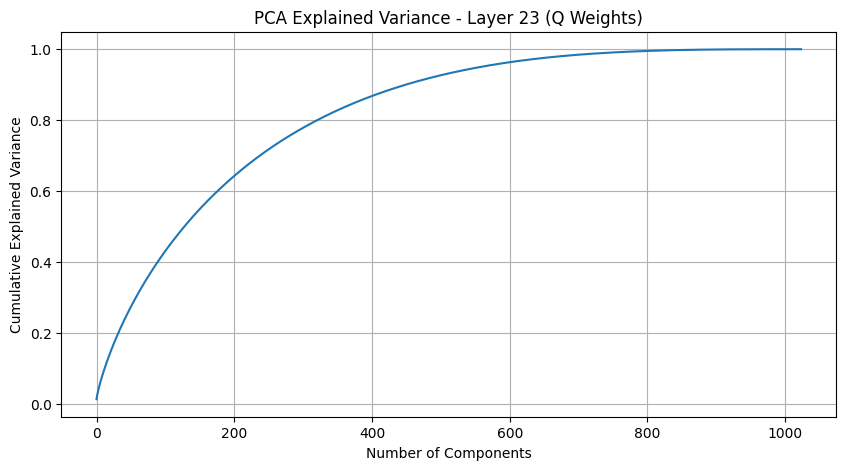

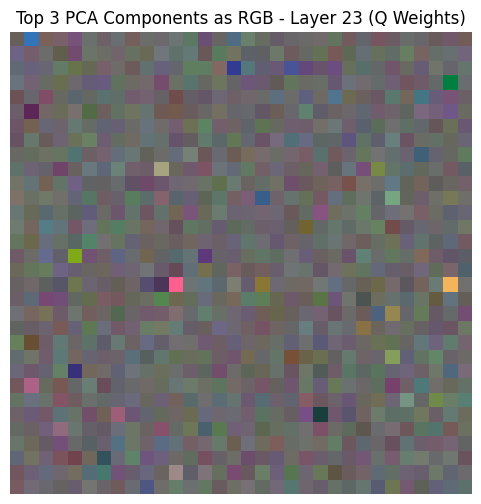


Analyzing K Weights:


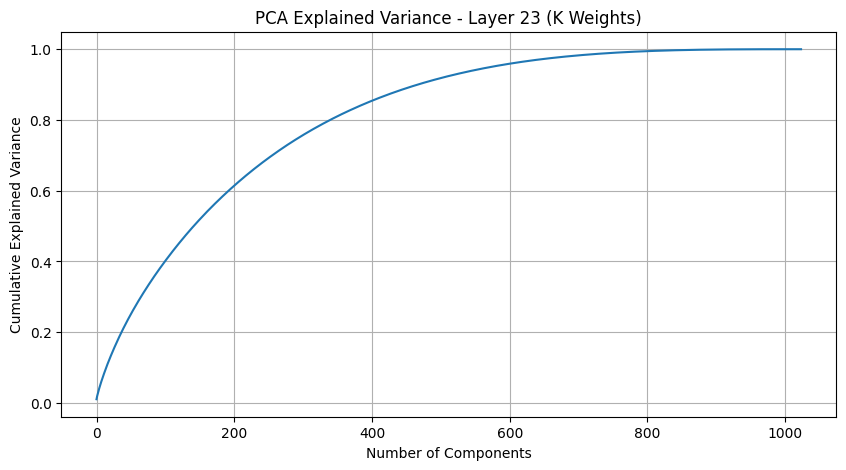

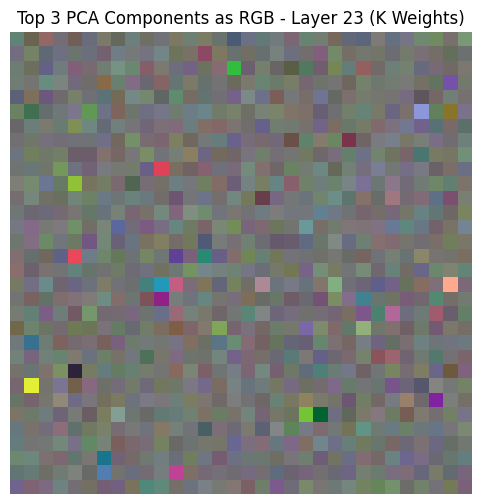


Analyzing V Weights:


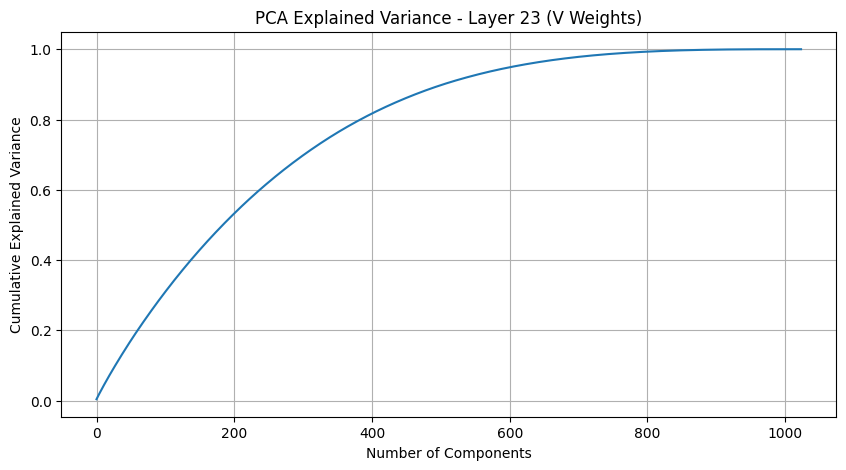

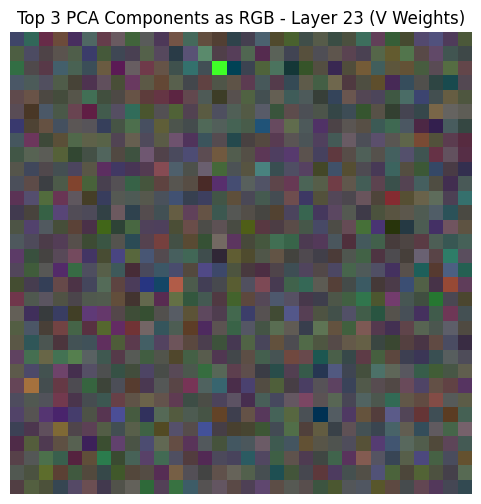

In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import timm
# Assuming 'vit' is your ViT model (e.g., a DINOv2 model)
# and it has been properly initialized and (if applicable) loaded with weights.

model = timm.create_model("vit_large_patch14_reg4_dinov2", pretrained=True, img_size=(1280, 1280), patch_size=14, num_classes=0)
# Function to extract QKV weights from a given layer
def extract_qkv_weights(model, layer_num):
    # Access blocks directly on the model
    qkv_layer = model.blocks[layer_num].attn.qkv
    qkv_weight = qkv_layer.weight
    
    # The qkv.weight tensor shape is typically (3 * embed_dim, embed_dim) 
    total_dim = qkv_weight.shape[0]
    dim_per_type = total_dim // 3

    q_weights = qkv_weight[:dim_per_type, :]
    k_weights = qkv_weight[dim_per_type:2*dim_per_type, :]
    v_weights = qkv_weight[2*dim_per_type:, :]
    
    return q_weights.detach().cpu().numpy(), k_weights.detach().cpu().numpy(), v_weights.detach().cpu().numpy()

# Helper function to perform PCA and visualize results
def _perform_and_visualize_pca(weights, weight_type, layer_num):
    """Fits PCA, plots explained variance, and visualizes top 3 PCs as RGB."""
    pca = PCA()
    pca.fit(weights)

    # --- Plot explained variance ratio ---
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_variance)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"PCA Explained Variance - Layer {layer_num} ({weight_type} Weights)")
    plt.grid(True)
    plt.show()
    
    # --- Visualize top 3 PCA components as RGB ---
    if pca.n_components_ >= 3:
        top3_pcs = pca.components_[:3, :] 

        n_features = top3_pcs.shape[1]
        img_dim = int(np.sqrt(n_features))
        
        if img_dim * img_dim == n_features:
            pc_images = top3_pcs.reshape(3, img_dim, img_dim)
            rgb_image = np.stack(pc_images, axis=-1)

            min_val = rgb_image.min()
            max_val = rgb_image.max()
            if max_val > min_val:
                 rgb_image_normalized = (rgb_image - min_val) / (max_val - min_val)
            else:
                 rgb_image_normalized = np.zeros_like(rgb_image)

            plt.figure(figsize=(6, 6))
            plt.imshow(rgb_image_normalized)
            plt.title(f"Top 3 PCA Components as RGB - Layer {layer_num} ({weight_type} Weights)")
            plt.axis('off') 
            plt.show()
        else:
            print(f"Layer {layer_num} ({weight_type}): Cannot reshape {n_features} features into a square image.")
    else:
        print(f"Layer {layer_num} ({weight_type}): Not enough components ({pca.n_components_}) for RGB visualization.")


# Function to analyze Q, K, V weights separately
def analyze_qkv_pca_distinctly(q_weights, k_weights, v_weights, layer_num):
    print(f"\n--- Analyzing Layer {layer_num} ---")
    
    print("\nAnalyzing Q Weights:")
    _perform_and_visualize_pca(q_weights, "Q", layer_num)
    
    print("\nAnalyzing K Weights:")
    _perform_and_visualize_pca(k_weights, "K", layer_num)
    
    print("\nAnalyzing V Weights:")
    _perform_and_visualize_pca(v_weights, "V", layer_num)


# Example usage: Analyze QKV weights from layer 5 distinctly
layer_num = 23  # Choose the layer you want to analyze
q_weights, k_weights, v_weights = extract_qkv_weights(model, layer_num)
analyze_qkv_pca_distinctly(q_weights, k_weights, v_weights, layer_num) # Use the new function

# You can loop through multiple layers if needed
# num_layers = len(model.blocks) # Get number of layers dynamically
# for layer_num in range(num_layers): 
#     q_weights, k_weights, v_weights = extract_qkv_weights(model, layer_num)
#     analyze_qkv_pca_distinctly(q_weights, k_weights, v_weights, layer_num)

In [2]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 85.2 MB/s eta 0:00:00
